Install Libraries

In [3]:
# Step 1: Import Libraries and Load Model
import os
import librosa
import torch
import torchaudio
import numpy as np
import pandas as pd
import re
from difflib import SequenceMatcher

from transformers import WhisperTokenizer, WhisperProcessor, WhisperFeatureExtractor, WhisperForConditionalGeneration

Transcribe the voices into text

In [4]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model with specified language for Bangla
model_path = "bangla-speech-processing/BanglaASR"  # Adjust this to your specific Whisper model path
feature_extractor = WhisperFeatureExtractor.from_pretrained(model_path)
tokenizer = WhisperTokenizer.from_pretrained(model_path, language="bn", task="transcribe")
processor = WhisperProcessor.from_pretrained(model_path, language="bn", task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained(model_path).to(device)
print("Model and components loaded successfully!")

# Function to transcribe audio and return transcription with label and class
def dataSegmentation(wav_path, label, class_label):
    print(f"Attempting to process: {wav_path}")
    try:
        # Load and resample the audio file to 16 kHz
        speech_array, sampling_rate = torchaudio.load(wav_path)
        print(f"Loaded audio file with sampling rate: {sampling_rate}")
        
        speech_array = speech_array[0].numpy()
        speech_array = librosa.resample(np.asarray(speech_array), orig_sr=sampling_rate, target_sr=16000)
        
        # Transcription
        input_features = feature_extractor(speech_array, sampling_rate=16000, return_tensors="pt").input_features.to(device)
        attention_mask = torch.ones_like(input_features, dtype=torch.long)  # Set attention mask

        with torch.no_grad():
            predicted_ids = model.generate(input_features=input_features, attention_mask=attention_mask)[0]
            transcription = processor.decode(predicted_ids, skip_special_tokens=True)
        
        print(f"Transcription: {transcription}")
        
        return transcription.strip(), label, class_label  # Return transcription, label, and class
    except Exception as e:
        print(f"Error processing file {wav_path}: {e}")
        return None, None, None

# Custom sorting function to handle alphanumeric sorting
def alphanumeric_sort(label):
    match = re.match(r"s(\d+)_v(\d+)", label)
    return int(match.group(1)) if match else float('inf')  # Sorts based on the number after 's'

# General processing function to handle audio files for dementia or non-dementia data
def process_audio_files(directory, class_label):
    rows = []
    
    # Get list of files and sort them by the label number
    files = [file for file in os.listdir(directory) if file.endswith('.wav')]
    files.sort(key=lambda x: alphanumeric_sort(os.path.splitext(x)[0]))  # Sort files based on the label number
    
    for file in files:
        wav_path = os.path.join(directory, file)
        label = os.path.splitext(file)[0]  # Using filename without extension as label
        transcribed_text, file_label, file_class = dataSegmentation(wav_path, label, class_label)
        
        if transcribed_text:  # Only add if transcription is successful
            rows.append({'label': file_label, 'transcribed_text': transcribed_text, 'class': file_class})
            print(f"Data appended: {transcribed_text[:30]}... , Label: {file_label}, Class: {file_class}")
        else:
            print(f"Empty or failed transcription for file: {wav_path}")
    
    # Convert rows to DataFrame
    df = pd.DataFrame(rows)
    return df

# Load and process both dementia and non-dementia data
dementia_directory = r"C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Dataset\Dementia"  # Path for dementia voices
non_dementia_directory = r"C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Dataset\NonDementia"  # Path for non-dementia voices

# Transcribe and save both datasets
dementia_df = process_audio_files(dementia_directory, class_label="Dementia")
non_dementia_df = process_audio_files(non_dementia_directory, class_label="Non-Dementia")

# Save the transcriptions to CSV
dementia_csv_path = r"C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Dementia_Transcriptions.csv"
non_dementia_csv_path = r"C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\NonDementia_Transcriptions.csv"

dementia_df.to_csv(dementia_csv_path, index=False, encoding='utf-8-sig')
non_dementia_df.to_csv(non_dementia_csv_path, index=False, encoding='utf-8-sig')

print(f"Dementia transcriptions saved to CSV file at: {dementia_csv_path}")
print(f"Non-Dementia transcriptions saved to CSV file at: {non_dementia_csv_path}")

Model and components loaded successfully!
Attempting to process: C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Dataset\Dementia\s1_v1.wav
Loaded audio file with sampling rate: 44100


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Transcription: আমি খবার উঠাও খুঁজে পাচচির না।
Data appended: আমি খবার উঠাও খুঁজে পাচচির না।... , Label: s1_v1, Class: Dementia
Attempting to process: C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Dataset\Dementia\s2_v1.wav
Loaded audio file with sampling rate: 44100
Transcription: তিনি কী খেয়াসি মনে করতে পাচ্ছি না।
Data appended: তিনি কী খেয়াসি মনে করতে পাচ্ছ... , Label: s2_v1, Class: Dementia
Attempting to process: C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Dataset\Dementia\s3_v1.wav
Loaded audio file with sampling rate: 44100
Transcription: ওয়াই হাবারটা রাখা হয়েওসে মনে নেই।
Data appended: ওয়াই হাবারটা রাখা হয়েওসে মনে... , Label: s3_v1, Class: Dementia
Attempting to process: C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Dataset\Dementia\s4_v1.wav
Loaded audio file with sampling rate: 44100
Transcription: হাঁশকে রাননাটা ও মডালার হয়েছে।
Data appended: হাঁশকে রাননাটা ও মডালার হয়েছে... , Label: s4_v1, Class: Dementia
Attempting to process: C:\Users\md

In [5]:
n = pd.read_csv(r'Dementia_Transcriptions.csv')
n.head(20)

,label,transcribed_text,class
0,s1_v1,আমি খবার উঠাও খুঁজে পাচচির না।,Dementia
1,s2_v1,তিনি কী খেয়াসি মনে করতে পাচ্ছি না।,Dementia
2,s3_v1,ওয়াই হাবারটা রাখা হয়েওসে মনে নেই।,Dementia
3,s4_v1,হাঁশকে রাননাটা ও মডালার হয়েছে।,Dementia
4,s5_v1,মানীর ক্লাশ্রা একটু এগিয়ে লাও।,Dementia
5,s6_v1,মার ইনেস মাস অনেক পছন্গ্রাথ।,Dementia
6,s7_v1,মুরগের টিউটা শ্বেণ্ড করে আনা।,Dementia
7,s8_v1,মার্ক দুটি ডিয়ে ভাষের মাংস ফেতে ইচ্ছে কর্ত্রে।,Dementia
8,s9_v1,ওয়ার পরে একটু ঘটা-আটি দরটার।,Dementia
9,s10_v1,আমার এখন উলা নেই।,Dementia


Matching with sentence dataset and Correct the Transcribed sentences 

In [6]:
# Load the transcribed and correct sentences CSV files for matching
transcribed_dementia_df = pd.read_csv(dementia_csv_path)
transcribed_dementia_df['label'] = transcribed_dementia_df['label'].str.replace(r'_v\d+', '', regex=True)
transcribed_non_dementia_df = pd.read_csv(non_dementia_csv_path)
transcribed_non_dementia_df['label'] = transcribed_non_dementia_df['label'].str.replace(r'_v\d+', '', regex=True)

# Load the correct sentences for dementia and non-dementia
corrected_dementia_df = pd.read_csv(r'C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\CorrectSen - dementia.csv')
corrected_non_dementia_df = pd.read_csv(r'C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\CorrectSen - NonDementia.csv')

# Function to correct individual words in sentences based on similarity
def correct_sentence_word_by_word(transcribed_sentence, correct_sentence):
    transcribed_words = transcribed_sentence.split()
    correct_words = correct_sentence.split()
    
    corrected_words = []
    for i, trans_word in enumerate(transcribed_words):
        if i < len(correct_words):
            # Calculate similarity between the transcribed and correct word
            match_ratio = SequenceMatcher(None, trans_word, correct_words[i]).ratio()
            
            # If the match ratio is below threshold, replace it with the correct word
            if match_ratio > 0.8:  # Adjust this threshold as needed
                corrected_words.append(trans_word)
            else:
                corrected_words.append(correct_words[i])
        else:
            # If transcribed sentence has more words, keep them as they are
            corrected_words.append(trans_word)
    
    # If correct sentence has more words, append them to the result
    corrected_words.extend(correct_words[len(transcribed_words):])
    
    return ' '.join(corrected_words)

# Correction function for transcriptions
def correct_transcriptions(transcribed_df, corrected_df, class_label):
    corrected_sentences = []
    for index, row in transcribed_df.iterrows():
        label = row['label']
        transcribed_sentence = row['transcribed_text']
        
        # Find the corresponding correct sentence
        correct_sentence_row = corrected_df.loc[corrected_df['label'] == label, 'sentences'].values
        if correct_sentence_row.size > 0:
            corrected_sentence_text = correct_sentence_word_by_word(transcribed_sentence, correct_sentence_row[0])
            corrected_sentences.append((label, corrected_sentence_text, class_label))
        else:
            corrected_sentences.append((label, transcribed_sentence, class_label))  # Keep original if no match found
    
    # Create a DataFrame with the corrected sentences
    final_corrected_df = pd.DataFrame(corrected_sentences, columns=['label', 'transcribed_text', 'class'])
    return final_corrected_df

# Apply corrections for dementia and non-dementia
final_corrected_dementia_df = correct_transcriptions(transcribed_dementia_df, corrected_dementia_df, "Dementia")
final_corrected_non_dementia_df = correct_transcriptions(transcribed_non_dementia_df, corrected_non_dementia_df, "Non-Dementia")

# Save final corrected CSVs
final_dementia_path = r'C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Final_Dementia_Transcriptions.csv'
final_non_dementia_path = r'C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Final_NonDementia_Transcriptions.csv'

final_corrected_dementia_df.to_csv(final_dementia_path, index=False, encoding='utf-8-sig')
final_corrected_non_dementia_df.to_csv(final_non_dementia_path, index=False, encoding='utf-8-sig')

print(f"Final corrected dementia transcriptions saved to {final_dementia_path}")
print(f"Final corrected non-dementia transcriptions saved to {final_non_dementia_path}")

# Display a preview of both DataFrames
print("Dementia Transcriptions DataFrame:")
print(final_corrected_dementia_df.head(10))
print("Non-Dementia Transcriptions DataFrame:")
print(final_corrected_non_dementia_df.head(20))


Final corrected dementia transcriptions saved to C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Final_Dementia_Transcriptions.csv
Final corrected non-dementia transcriptions saved to C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Final_NonDementia_Transcriptions.csv
Dementia Transcriptions DataFrame:
  label                             transcribed_text     class
0    s1              আমি খবার কোথাও খুঁজে পাচ্ছি না।  Dementia
1    s2             আমি কি খেয়েছি মনে করতে পারছি না।  Dementia
2    s3            কোথায় হাবারটা রাখা হয়েছে মনে নেই।  Dementia
3    s4          আজকের রাননাটা মজাদার হয়েছে। হয়েছে।  Dementia
4    s5                পানির গ্লাসটা একটু এগিয়ে দাও।  Dementia
5    s6                     মার ইলিশ মাছ অনেক পছন্দ।  Dementia
6    s7                  মুরগের ডিমটা সিদ্ধ করে আনো।  Dementia
7    s8  আমার রুটি দিয়ে হাঁসের মাংস খেতে ইচ্ছা করছে।  Dementia
8    s9               খাওয়ার পর একটু হাটাহাটি দরটার।  Dementia
9   s10                         আমার এখন ক্ষুধা নেই।

Merged Dementia and Non-Dementia transcribed sentences

In [7]:
# Load the two transcription CSV files
dementia_df = pd.read_csv(final_dementia_path)
non_dementia_df = pd.read_csv(final_non_dementia_path)

# Prefix the labels to avoid conflicts
dementia_df['label'] = 'D_' + dementia_df['label'].astype(str)
non_dementia_df['label'] = 'ND_' + non_dementia_df['label'].astype(str)

# Merge the two dataframes
merged_df = pd.concat([dementia_df, non_dementia_df], ignore_index=True)

# Save the merged dataframe to a new CSV file
merged_df.to_csv(r'C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Merged_Dataset.csv', index=False, encoding='utf-8-sig')

print("Merged file saved successfully.")

print(merged_df.head(40))

Merged file saved successfully.
    label                             transcribed_text     class
0    D_s1              আমি খবার কোথাও খুঁজে পাচ্ছি না।  Dementia
1    D_s2             আমি কি খেয়েছি মনে করতে পারছি না।  Dementia
2    D_s3            কোথায় হাবারটা রাখা হয়েছে মনে নেই।  Dementia
3    D_s4          আজকের রাননাটা মজাদার হয়েছে। হয়েছে।  Dementia
4    D_s5                পানির গ্লাসটা একটু এগিয়ে দাও।  Dementia
5    D_s6                     মার ইলিশ মাছ অনেক পছন্দ।  Dementia
6    D_s7                  মুরগের ডিমটা সিদ্ধ করে আনো।  Dementia
7    D_s8  আমার রুটি দিয়ে হাঁসের মাংস খেতে ইচ্ছা করছে।  Dementia
8    D_s9               খাওয়ার পর একটু হাটাহাটি দরটার।  Dementia
9   D_s10                         আমার এখন ক্ষুধা নেই।  Dementia
10  D_s11                  ভাত খেতে ইচ্ছা করছে না এখন।  Dementia
11  D_s12                      মার অনেক ক্ষুধা লেগেছে।  Dementia
12  D_s13                    আমি হাসের ডিমটা বেশি খাই।  Dementia
13  D_s14                    সবাই আসো একসাথে খেতে বসি।  De

Remove (দাঁড়ি) and extra words

In [8]:
# Load the merged CSV file
merged_df = pd.read_csv(r'C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Merged_Dataset.csv')

# Function to remove text after (and including) the first Bangla period (দাঁড়ি)
def clean_sentence(sentence):
    # Split the sentence at the first occurrence of '।'
    parts = sentence.split('।', 1)
    cleaned_sentence = parts[0] if len(parts) > 1 else sentence
    # Keep the first part only, discard the rest
    # Remove commas (,) from the sentence
    return cleaned_sentence.replace(',', '')

# Apply the cleaning function to the transcribed_text column
merged_df['transcribed_text'] = merged_df['transcribed_text'].apply(clean_sentence)

# Save the cleaned dataset to a new CSV file
merged_df.to_csv(r'C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Merged_Dataset.csv', index=False, encoding='utf-8-sig')

print("Unwanted parts removed successfully. Cleaned file saved.")

merged_df.head(40)

Unwanted parts removed successfully. Cleaned file saved.


,label,transcribed_text,class
0,D_s1,আমি খবার কোথাও খুঁজে পাচ্ছি না,Dementia
1,D_s2,আমি কি খেয়েছি মনে করতে পারছি না,Dementia
2,D_s3,কোথায় হাবারটা রাখা হয়েছে মনে নেই,Dementia
3,D_s4,আজকের রাননাটা মজাদার হয়েছে,Dementia
4,D_s5,পানির গ্লাসটা একটু এগিয়ে দাও,Dementia
5,D_s6,মার ইলিশ মাছ অনেক পছন্দ,Dementia
6,D_s7,মুরগের ডিমটা সিদ্ধ করে আনো,Dementia
7,D_s8,আমার রুটি দিয়ে হাঁসের মাংস খেতে ইচ্ছা করছে,Dementia
8,D_s9,খাওয়ার পর একটু হাটাহাটি দরটার,Dementia
9,D_s10,আমার এখন ক্ষুধা নেই,Dementia


In [9]:
merged_df['class'].value_counts()

class
Dementia        170
Non-Dementia    170
Name: count, dtype: int64

In [2]:
import re
import pandas as pd
from bnlp import BengaliWord2Vec
from tqdm import tqdm
import time
import logging
from multiprocessing import Pool, cpu_count

# Setup logging
logging.basicConfig(level=logging.INFO)

# Initialize BengaliWord2Vec with a print confirmation
bwv = BengaliWord2Vec()
print("BengaliWord2Vec model loaded successfully.")

# Define Bangla stop words (sample, add more as needed)
bangla_stopwords = ['আমি', 'তুমি', 'সে', 'এটা', 'ওটা', 'যা', 'এই', 'ওই', 'কিছু', 'কেন', 'যদি', 'কখন', 'কি']

# Predefined Bangla synonym dictionary (for demonstration)
bangla_synonym_dict = {
    'খেতে': ['গ্রহণ', 'ভক্ষণ'],
    'খাবার': ['আহার', 'ভোজন'],
    'মনে': ['স্মরণ', 'ধারণা'],
    'রান্না': ['পাক', 'পক'],
    'পছন্দ': ['প্রিয়', 'আকর্ষণ'],
    # Add more Bangla synonyms relevant to the research context
}

# Similar word cache to speed up augmentation
similar_word_cache = {}

def get_similar_word(word, n):
    logging.info(f"Fetching similar word for: {word}")
    if word not in similar_word_cache:
        try:
            # Skip if the word is a stop word
            if word in bangla_stopwords:
                similar_word_cache[word] = [(word, 1.0)] * 5
            else:
                # Try to get similar words from the Word2Vec model
                similar_word_cache[word] = bwv.get_most_similar_words(word, topn=5)
        except KeyError:
            # Use predefined synonyms if the word is not in Word2Vec model
            if word in bangla_synonym_dict:
                similar_word_cache[word] = [(syn, 1.0) for syn in bangla_synonym_dict[word]]
            else:
                # If no similar words or synonyms, fall back to the original word
                similar_word_cache[word] = [(word, 1.0)] * 5
    return similar_word_cache[word][n % len(similar_word_cache[word])][0]

def data_augmentation(args):
    text, label, n = args
    try:
        pattern = r'\[.*?\]'
        text = re.sub(pattern, '', text)  # Remove text inside square brackets
        words = text.split()
        similar_words = [get_similar_word(word, n) for word in words]
        augmented_text = " ".join(similar_words)
        return augmented_text, label
    except Exception as e:
        logging.error(f"Error during augmentation: {e}")
        return text, label  # Return the original if an error occurs

def augment_for_n(df, n):
    augmented_data = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f'Augmentation Round {n+1}'):
        augmented_data.append(data_augmentation((row['transcribed_text'], row['class'], n)))
    return pd.DataFrame(augmented_data, columns=['augmented_text', 'class'])

# Load the dataset
file_path = r'C:\Users\AsifAK\Desktop\Dementia Research\Merged_Dataset.csv'
df = pd.read_csv(file_path)

# Adjust the number of augmentations and dataset size
num_augmentations = 4  # Number of augmentation rounds (adjust as needed)

# Track the total augmentation time
start_time = time.time()

# Data augmentation loop
for aug in range(num_augmentations):
    df2 = augment_for_n(df, aug)
    df = pd.concat([df, df2.rename(columns={'augmented_text': 'transcribed_text'})], ignore_index=True)

df.reset_index(drop=True, inplace=True)

# Save the augmented dataset
augmented_csv_path = r'C:\Users\AsifAK\Desktop\Dementia Research\Augmented_Dataset.csv'
df.to_csv(augmented_csv_path, columns=['transcribed_text', 'class'], index=False, encoding='utf-8-sig')

# Track and print the total time taken
end_time = time.time()
print(f"Augmented dataset saved successfully. Total time taken: {end_time - start_time:.2f} seconds.")



INFO:gensim.utils:loading Word2Vec object from C:\Users\AsifAK\bnlp\models\bnwiki_word2vec.model
INFO:gensim.utils:loading wv recursively from C:\Users\AsifAK\bnlp\models\bnwiki_word2vec.model.wv.* with mmap=None
INFO:gensim.utils:loading vectors from C:\Users\AsifAK\bnlp\models\bnwiki_word2vec.model.wv.vectors.npy with mmap=None
INFO:gensim.utils:loading syn1neg from C:\Users\AsifAK\bnlp\models\bnwiki_word2vec.model.syn1neg.npy with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:Word2Vec lifecycle event {'fname': 'C:\\Users\\AsifAK\\bnlp\\models\\bnwiki_word2vec.model', 'datetime': '2024-11-15T08:44:22.859221', 'gensim': '4.3.2', 'python': '3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'loaded'}


BengaliWord2Vec model loaded successfully.


Augmentation Round 1:   0%|          | 0/40 [00:00<?, ?it/s]INFO:root:Fetching similar word for: আমি
INFO:root:Fetching similar word for: খবার
INFO:root:Fetching similar word for: কোথাও
INFO:root:Fetching similar word for: খুঁজে
INFO:root:Fetching similar word for: পাচ্ছি
INFO:root:Fetching similar word for: না
INFO:root:Fetching similar word for: আমি
INFO:root:Fetching similar word for: কি
INFO:root:Fetching similar word for: খেয়েছি
INFO:root:Fetching similar word for: মনে
INFO:root:Fetching similar word for: করতে
INFO:root:Fetching similar word for: পারছি
INFO:root:Fetching similar word for: না
Augmentation Round 1:   5%|▌         | 2/40 [00:00<00:02, 16.74it/s]INFO:root:Fetching similar word for: কোথায়
INFO:root:Fetching similar word for: হাবারটা
INFO:root:Fetching similar word for: রাখা
INFO:root:Fetching similar word for: হয়েছে
INFO:root:Fetching similar word for: মনে
INFO:root:Fetching similar word for: নেই
INFO:root:Fetching similar word for: আজকের
INFO:root:Fetching similar wor

Augmented dataset saved successfully. Total time taken: 12.43 seconds.


In [5]:
df['class'].value_counts()

NameError: name 'df' is not defined

In [10]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

Remove stop words and generate Word Cloud

Cleaned dataset saved to: C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Cleaned_Dataset.csv


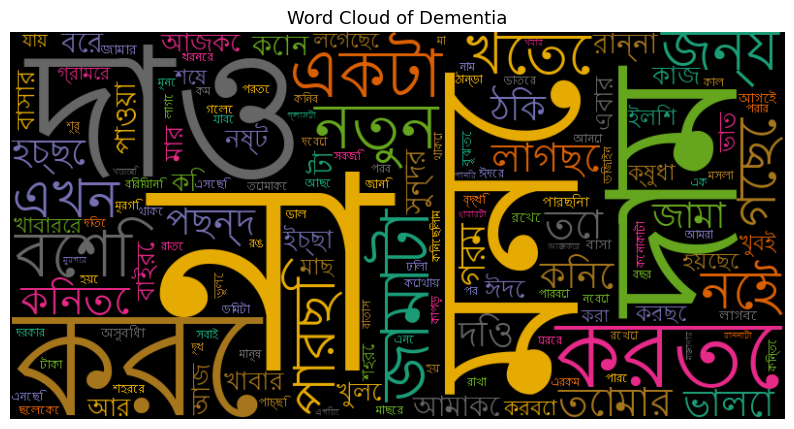

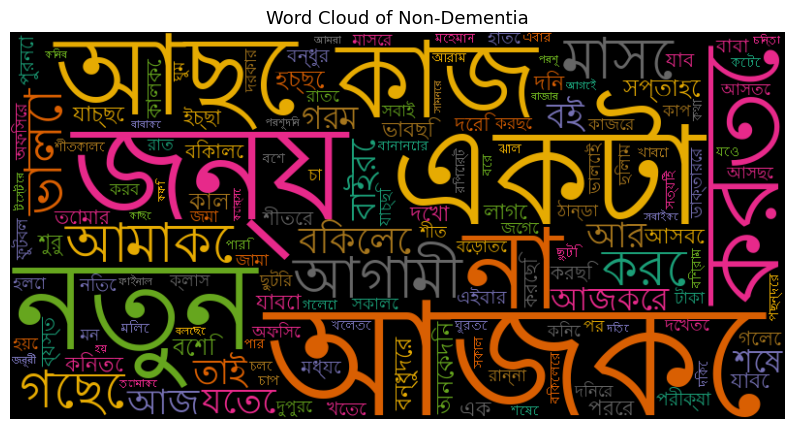

In [11]:
#"আমি", "আমার", "অনেক", "এই", "করে", "হবে", "হতে", "হয়", "করা", "এবং", "তো", "কিন্তু", "যদি", "বা", "হয়নি", "এখন", "আগে", "তাই",
#"আবার", "সব", "কিছু", "তার", "জন্য", "থেকে", "পরে", "দিয়ে", "সঙ্গে", "পর্যন্ত", "দিকে", "মধ্যে", "এর", "আর", "সেখানে", "এখানে", "অথবা", "তারপর", "ও"

bangla_stop_words = ["এবং", "বা", "কিন্তু", "যে", "এটি", "সে", "তার", "তাদের", "আমাদের", "আমি", "তুমি", "তিনি", 
    "তার", "এর", "হতে", "ছিল", "হবে", "হ্যাঁ", "যেমন", "যখন", "যদি", "কোথাও", "এখানে", 
    "সেখানে", "কেন", "তখন", "খুব", "কিছু", "সব", "অনেক", "অধিকাংশ", "কখনও", "তাও", "আমার", 
    "মাঝে", "থেকে", "উপর", "নিচে", "মতো", "একটু", "আবার", "আগে", "পরে", "সাথে", "এই", "ঐ", 
    "যেখানে", "কিভাবে", "কত"
    ]

# Define a preprocessing function
def preprocess_text(sentence, stop_words):
    # Split into words
    words = sentence.split()
    # Remove stop words, single-character fragments, and non-Bangla patterns
    words = [word for word in words if word not in stop_words and len(word) > 1 and re.match(r'^[অ-হা-য়]+$', word)]
    # Join back into a cleaned sentence
    cleaned_sentence = " ".join(words)
    return cleaned_sentence if cleaned_sentence else "EMPTY"  # Replace empty strings with "EMPTY"

# Create a cleaned dataset
cleaned_df = merged_df.copy()
cleaned_df['cleaned_text'] = cleaned_df['transcribed_text'].apply(lambda x: preprocess_text(x, bangla_stop_words))

# Save the cleaned dataframe to a new CSV file
cleaned_file_path = r'C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Cleaned_Dataset.csv'  # Update the save path
cleaned_df.to_csv(cleaned_file_path, index=False, encoding='utf-8-sig')
print(f"Cleaned dataset saved to: {cleaned_file_path}")

# Generate Word Cloud
def generate_wordcloud(data, title):
    wc = WordCloud(
        font_path=font_path,
        width=800,
        height=400,
        max_words=150,
        colormap="Dark2"
    ).generate_from_frequencies(dict(data.values))
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud of {title}", fontsize=13)
    plt.show()

# Generate Word Clouds by Category
def generate_category_wordclouds(df):
    for category in df['class'].unique():
        word_counts = Counter(" ".join(df[df['class'] == category]['cleaned_text']).split())
        word_count_df = pd.DataFrame(word_counts.most_common(500), columns=['Common_words', 'count'])
        generate_wordcloud(word_count_df, category)

# Parameters
font_path = r'C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Dataset\Lohit_14-04-2007.ttf'

# Generate Word Clouds
generate_category_wordclouds(cleaned_df)

Only TF-IDF features

In [12]:
# Define a custom tokenizer for TF-IDF
def custom_bangla_tokenizer(text):
    return text.split()  # Tokenize by splitting on spaces

# Initialize TF-IDF vectorizer for word-level unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=custom_bangla_tokenizer,  # Custom tokenizer for Bangla
    ngram_range=(1, 3),  # Generate unigrams and bigrams
    max_features=2500  # Limit to top 1000 features
)

# Fit and transform the cleaned text
X_tfidf = tfidf_vectorizer.fit_transform(cleaned_df['cleaned_text'])

# Save the TF-IDF vectorizer for future use
tfidf_vectorizer_path = r'C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Features\TFIDF_Vectorizer.pkl'
with open(tfidf_vectorizer_path, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print(f"TF-IDF vectorizer saved to: {tfidf_vectorizer_path}")

# Save the TF-IDF matrix for further use
tfidf_matrix_path = r'C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Features\TFIDF_Features.pkl'
with open(tfidf_matrix_path, 'wb') as f:
    pickle.dump(X_tfidf, f)

# Display some information about the TF-IDF features
print("Number of features:", X_tfidf.shape[1])  # Total number of features
print("TF-IDF feature names:", tfidf_vectorizer.get_feature_names_out()[:70])  # Show first 60 feature names

TF-IDF vectorizer saved to: C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\Features\TFIDF_Vectorizer.pkl
Number of features: 2500
TF-IDF feature names: ['অনলাইনে জামা কিনে' 'অনুষ্ঠানটি' 'অনুষ্ঠানটি সবাই'
 'অনুষ্ঠানটি সবাই উপভোগ' 'অনেকক্ষণ' 'অনেকক্ষণ রাতে' 'অনেকক্ষণ রাতে আর'
 'অনেকটা' 'অনেকটা পার' 'অনেকটা পার গেছে' 'অনেকটা বেশি' 'অনেকদিন'
 'অনেকদিন আজকে' 'অনেকদিন আজকে কম্পিউটার' 'অনেকদিন গেছে'
 'অনেকদিন গেছে জামা' 'অনেকদিন ধরে' 'অনেকদিন ধরে চাকরি' 'অনেকদিন পর'
 'অনেকদিন পর পুরনো' 'অনেকদিন হচ্ছে' 'অনেকদিন হচ্ছে দাদা' 'অনেকেই'
 'অনেকেই তেলুভাজা' 'অনেকেই তেলুভাজা খাবার' 'অপ্রয়োজনীয়' 'অপ্রয়োজনীয় কাপড়'
 'অপ্রয়োজনীয় কাপড় কিনে' 'অফিস' 'অফিস আসব' 'অফিসে' 'অফিসের' 'অসুবিধা'
 'অসুবিধা হচ্ছে' 'আগামী' 'আগামী মাসে' 'আগামী মাসে একটা' 'আগামী মাসে নতুন'
 'আগামী সপ্তাহে' 'আগেই' 'আগেই ফিরে' 'আছে' 'আজ' 'আজকে' 'আজকে আমাকে'
 'আজকে বিকেলে' 'আজকে বিকেলে আমাকে' 'আজকে বিকেলে বৈমেলা' 'আজকে বিরিয়ানি'
 'আজকে বিরিয়ানি রান্না' 'আজকে বৃষ্টির' 'আজকে বৃষ্টির পর' 'আজকে ব্যস্ত'
 'আজকে ব্যস্ত ছিলাম' 'আজকে যাওয়াই' 

c:\Users\mdnah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF and Word2Vec (optional)

In [9]:
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Define a custom tokenizer for TF-IDF
def custom_bangla_tokenizer(text):
    return text.split()  # Tokenize by splitting on spaces

# Initialize TF-IDF vectorizer for word-level unigrams, bigrams, and trigrams
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=custom_bangla_tokenizer,  # Custom tokenizer for Bangla
    ngram_range=(1, 3),  # Generate unigrams, bigrams, and trigrams
    max_features=2500  # Limit to top 2500 features
)

# Fit and transform the cleaned text with TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(cleaned_df['cleaned_text'])

# Save the TF-IDF vectorizer for future use
tfidf_vectorizer_path = r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\Features\TFIDF_Vectorizer.pkl'
with open(tfidf_vectorizer_path, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print(f"TF-IDF vectorizer saved to: {tfidf_vectorizer_path}")

# Save the TF-IDF matrix for further use
tfidf_matrix_path = r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\Features\TFIDF_Features.pkl'
with open(tfidf_matrix_path, 'wb') as f:
    pickle.dump(X_tfidf, f)

# Display some information about the TF-IDF features
print("Number of TF-IDF features:", X_tfidf.shape[1])
print("TF-IDF feature names:", tfidf_vectorizer.get_feature_names_out()[:70])  # Show first 70 feature names

# ===== Word2Vec Feature Extraction =====

# Tokenize sentences for Word2Vec training
sentences = [sentence.split() for sentence in cleaned_df['cleaned_text']]

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Save the Word2Vec model for future use
word2vec_model_path = r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\Features\Word2Vec_Model.pkl'
word2vec_model.save(word2vec_model_path)
print(f"Word2Vec model saved to: {word2vec_model_path}")

# Generate sentence embeddings by averaging word embeddings
def get_sentence_embedding(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)  # Return zero vector if no words are in the model
    return np.mean(word_vectors, axis=0)

# Create Word2Vec sentence embeddings
X_word2vec = np.array([get_sentence_embedding(text, word2vec_model) for text in cleaned_df['cleaned_text']])

# Save Word2Vec sentence embeddings for further use
word2vec_matrix_path = r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\Features\Word2Vec_Features.pkl'
with open(word2vec_matrix_path, 'wb') as f:
    pickle.dump(X_word2vec, f)
print(f"Word2Vec embeddings saved to: {word2vec_matrix_path}")

# Combine TF-IDF features and Word2Vec embeddings into a single feature set
from scipy.sparse import hstack
X_combined = hstack([X_tfidf, X_word2vec])

# Save the combined features for future use
combined_features_path = r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\Features\Combined_Features.pkl'
with open(combined_features_path, 'wb') as f:
    pickle.dump(X_combined, f)
print(f"Combined features saved to: {combined_features_path}")

# Display some information about the combined features
print("Combined feature shape:", X_combined.shape)


TF-IDF vectorizer saved to: C:\Users\AsifAK\Desktop\Code_Detect_Dementia\Features\TFIDF_Vectorizer.pkl
Number of TF-IDF features: 2500
TF-IDF feature names: ['অন' 'অন দিও' 'অন দিও তাহলে' 'অনলাইনে' 'অনলাইনে কিভাবে'
 'অনলাইনে কিভাবে আমাকে' 'অনুষ্ঠানটি' 'অনুষ্ঠানটি সবাই'
 'অনুষ্ঠানটি সবাই উপভোগ' 'অনেকক্ষণ' 'অনেকক্ষণ রাতে' 'অনেকক্ষণ রাতে ঘুম'
 'অনেকটা' 'অনেকটা পার' 'অনেকটা পার গেছে' 'অনেকটা বেশি' 'অনেকদিন'
 'অনেকদিন আজকে' 'অনেকদিন আজকে একটু' 'অনেকদিন গেছে' 'অনেকদিন গেছে জামা'
 'অনেকদিন ধরে' 'অনেকদিন ধরে চাকরি' 'অনেকদিন পর' 'অনেকদিন পর পুরনো'
 'অনেকদিন হচ্ছে' 'অনেকদিন হচ্ছে দাদা' 'অনেকেই' 'অনেকেই খাবার'
 'অনেকেই খাবার খুব' 'অপ্রয়োজনীয়' 'অপ্রয়োজনীয় কাপড়' 'অপ্রয়োজনীয় কাপড় কিনে'
 'অফিস' 'অফিস একটু' 'অফিস একটু আসব' 'অফিসে' 'অফিসে একটা'
 'অফিসে একটা জরুরি' 'অফিসে কাজের' 'অফিসে কাজের চাপ' 'অফিসে ব্যস্ত'
 'অফিসে ব্যস্ত ছিলা' 'অফিসের' 'অফিসের নতুন' 'অফিসের নতুন পোশাক'
 'অফিসের পিকনিকের' 'অফিসের পিকনিকের প্রস্তুতিনিতে' 'অফিসের সবাইকে'
 'অফিসের সবাইকে রেস্টোরেন্টে' 'অবস্থাটা' 'অবস্থাটা ভালো'
 'অবস্থা

c:\Users\AsifAK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


See TF-IDF features file

In [19]:
import pickle

# Load the TF-IDF vectorizer
tfidf_vectorizer_path = r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\Features\TFIDF_Vectorizer.pkl'
with open(tfidf_vectorizer_path, 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

# Load the TF-IDF feature matrix
tfidf_matrix_path = r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\Features\TFIDF_Features.pkl'
with open(tfidf_matrix_path, 'rb') as f:
    X_tfidf = pickle.load(f)

feature_names = tfidf_vectorizer.get_feature_names_out()
print("First 10 features:", feature_names[:10])  # View the first 10 features

print("Vocabulary size:", len(feature_names))
print("Vocabulary sample:", list(tfidf_vectorizer.vocabulary_.items())[:10])  # View first 10 terms

print("TF-IDF Matrix Shape:", X_tfidf.shape)  # (num_documents, num_features)

dense_matrix = X_tfidf[:10].toarray()  # Convert the first 10 rows to dense format
print("Dense Matrix Sample:\n", dense_matrix)

df_features = pd.DataFrame(dense_matrix, columns=feature_names)
print(df_features.head())  # View the feature weights for the first few documents

# Convert the full matrix to dense format
dense_tfidf = X_tfidf.toarray()

# Save as a DataFrame
tfidf_df = pd.DataFrame(dense_tfidf, columns=tfidf_vectorizer.get_feature_names_out())

# Save to a CSV
csv_path = '/content/drive/MyDrive/Important File/Testing_Transcription/CSVTFIDF_Features.csv'
tfidf_df.to_csv(csv_path, index=False, encoding='utf-8-sig')

print(f"TF-IDF features saved to: {csv_path}")



First 10 features: ['অন' 'অন দিও' 'অন দিও তাহলে' 'অনলাইনে' 'অনলাইনে কিভাবে'
 'অনলাইনে কিভাবে আমাকে' 'অনুষ্ঠানটি' 'অনুষ্ঠানটি সবাই'
 'অনুষ্ঠানটি সবাই উপভোগ' 'অনেকক্ষণ']
Vocabulary size: 2500
Vocabulary sample: [('কোথাও', 768), ('পাচ্ছি', 1100), ('না', 966), ('কোথাও পাচ্ছি', 772), ('পাচ্ছি না', 1101), ('কোথাও পাচ্ছি না', 773), ('কি', 679), ('মনে', 1757), ('করতে', 537), ('পারছি', 1120)]
TF-IDF Matrix Shape: (340, 2500)
Dense Matrix Sample:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.26453621]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
    অন  অন দিও  অন দিও তাহলে  অনলাইনে  অনলাইনে কিভাবে  অনলাইনে কিভাবে আমাকে  \
0  0.0     0.0           0.0      0

OSError: Cannot save file into a non-existent directory: '\content\drive\MyDrive\Important File\Testing_Transcription'

LR using TF-IDF

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
Model saved to: C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\ML_Models\Logistic_Regression_Model.pkl
Cross-Validation Accuracy: 0.74 ± 0.03
Training Accuracy: 1.00
Testing Accuracy: 0.76
Final Accuracy (Average of Training and Testing): 0.88
Logistic Regression Classification Report:
              

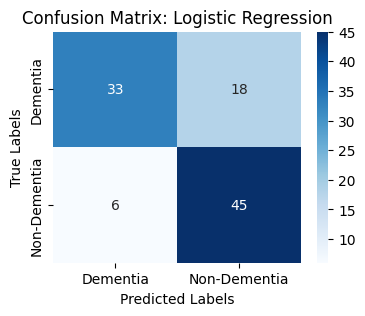

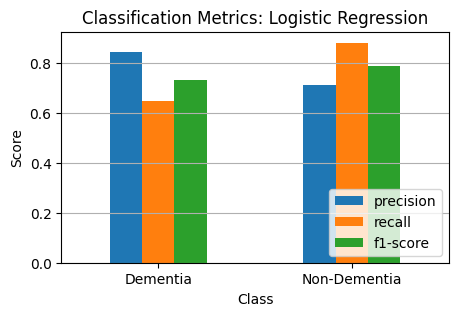

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load target variable
y = cleaned_df['class']  # Dementia or Non-Dementia

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converts 'Dementia'/'Non-Dementia' to numeric

print(y_encoded)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Initialize Logistic Regression model with regularization and class balancing
model = LogisticRegression(max_iter=1000, random_state=42, C=0.1, class_weight='balanced')
model.fit(X_train, y_train)

# Save the trained model for future use
model_path = r'C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\ML_Models\Logistic_Regression_Model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"Model saved to: {model_path}")

# Evaluate cross-validation accuracy
cv_scores = cross_val_score(model, X_tfidf, y_encoded, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Predict on the test data
y_pred = model.predict(X_test)

# Training accuracy
y_train_pred = model.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {training_accuracy:.2f}")

# Testing accuracy
testing_accuracy = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy: {testing_accuracy:.2f}")

# Final accuracy summary
final_accuracy = (training_accuracy + testing_accuracy) / 2  # Average of training and testing accuracy
print(f"Final Accuracy (Average of Training and Testing): {final_accuracy:.2f}")

# Evaluate the model
print("Logistic Regression Classification Report:")
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
print(pd.DataFrame(report).transpose())

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix as Heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

# Extract metrics for visualization
metrics_df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

# Visualize Precision, Recall, and F1-Score
metrics_df.plot(kind='bar', figsize=(5, 3))
plt.title('Classification Metrics: Logistic Regression')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

LR using Word2vec

Model saved to: C:\Users\AsifAK\Desktop\Code_Detect_Dementia\ML_Models\Logistic_Regression_Model_Word2Vec.pkl
Cross-Validation Accuracy: 0.60 ± 0.04
Training Accuracy: 0.74
Testing Accuracy: 0.67
Logistic Regression Classification Report:
              precision    recall  f1-score     support
Dementia       0.660377  0.686275  0.673077   51.000000
Non-Dementia   0.673469  0.647059  0.660000   51.000000
accuracy       0.666667  0.666667  0.666667    0.666667
macro avg      0.666923  0.666667  0.666538  102.000000
weighted avg   0.666923  0.666667  0.666538  102.000000
Confusion Matrix:
[[35 16]
 [18 33]]


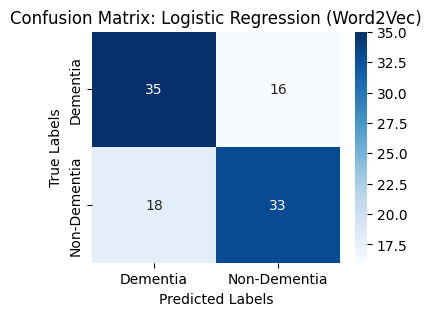

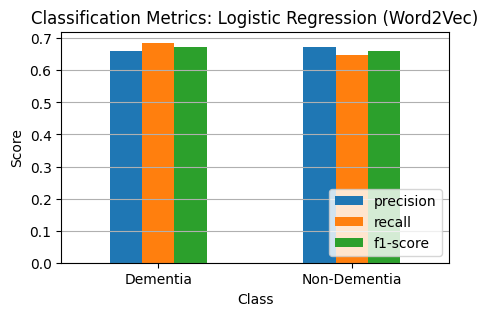

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# Load target variable
y = cleaned_df['class']  # Dementia or Non-Dementia

# Encode target variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converts 'Dementia'/'Non-Dementia' to numeric

# Prepare Word2Vec features (assuming `X_word2vec` is already generated)
X_word2vec = np.array(X_word2vec)  # Convert to numpy array if not already

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_word2vec, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Initialize Logistic Regression model with regularization and class balancing
model = LogisticRegression(max_iter=1000, random_state=42, C=0.1, class_weight='balanced')
model.fit(X_train, y_train)

# Save the trained model for future use
model_path = r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\ML_Models\Logistic_Regression_Model_Word2Vec.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"Model saved to: {model_path}")

# Evaluate cross-validation accuracy
cv_scores = cross_val_score(model, X_word2vec, y_encoded, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Predict on the test data
y_pred = model.predict(X_test)

# Training accuracy
y_train_pred = model.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {training_accuracy:.2f}")

# Testing accuracy
testing_accuracy = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy: {testing_accuracy:.2f}")

# Evaluate the model
print("Logistic Regression Classification Report:")
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
print(pd.DataFrame(report).transpose())

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix as Heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: Logistic Regression (Word2Vec)')
plt.show()

# Extract metrics for visualization
metrics_df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

# Visualize Precision, Recall, and F1-Score
metrics_df.plot(kind='bar', figsize=(5, 3))
plt.title('Classification Metrics: Logistic Regression (Word2Vec)')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()


LR with Combined features

Loaded combined feature matrix from: C:\Users\AsifAK\Desktop\Code_Detect_Dementia\Features\Combined_Features.pkl
Model saved to: C:\Users\AsifAK\Desktop\Code_Detect_Dementia\ML_Models\Logistic_Regression_Model_Combined.pkl
Cross-Validation Accuracy: 0.70 ± 0.02
Training Accuracy: 1.00
Testing Accuracy: 0.75
Logistic Regression Classification Report:
              precision    recall  f1-score     support
Dementia       0.861111  0.607843  0.712644   51.000000
Non-Dementia   0.696970  0.901961  0.786325   51.000000
accuracy       0.754902  0.754902  0.754902    0.754902
macro avg      0.779040  0.754902  0.749484  102.000000
weighted avg   0.779040  0.754902  0.749484  102.000000
Confusion Matrix:
[[31 20]
 [ 5 46]]


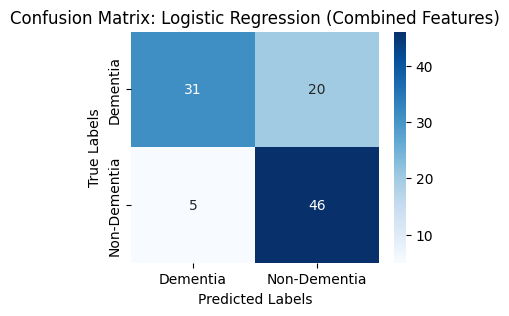

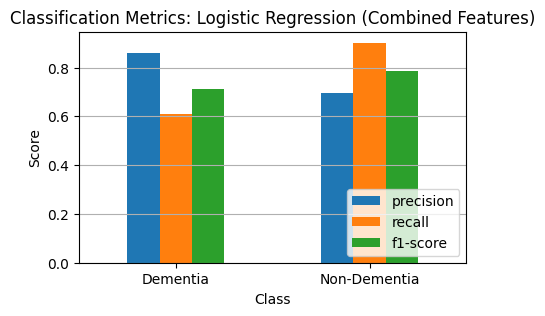

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# Load target variable
y = cleaned_df['class']  # Dementia or Non-Dementia

# Encode target variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converts 'Dementia'/'Non-Dementia' to numeric

# Load pre-saved combined features
combined_features_path = r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\Features\Combined_Features.pkl'
with open(combined_features_path, 'rb') as f:
    X_combined = pickle.load(f)
print(f"Loaded combined feature matrix from: {combined_features_path}")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Initialize Logistic Regression model with regularization and class balancing
model = LogisticRegression(max_iter=1000, random_state=42, C=0.1, class_weight='balanced')
model.fit(X_train, y_train)

# Save the trained model for future use
model_path = r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\ML_Models\Logistic_Regression_Model_Combined.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"Model saved to: {model_path}")

# Evaluate cross-validation accuracy
cv_scores = cross_val_score(model, X_combined, y_encoded, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Predict on the test data
y_pred = model.predict(X_test)

# Training accuracy
y_train_pred = model.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {training_accuracy:.2f}")

# Testing accuracy
testing_accuracy = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy: {testing_accuracy:.2f}")

# Evaluate the model
print("Logistic Regression Classification Report:")
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
print(pd.DataFrame(report).transpose())

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix as Heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: Logistic Regression (Combined Features)')
plt.show()

# Extract metrics for visualization
metrics_df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

# Visualize Precision, Recall, and F1-Score
metrics_df.plot(kind='bar', figsize=(5, 3))
plt.title('Classification Metrics: Logistic Regression (Combined Features)')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()


Random Forest with Tf-Idf

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pickle

# Load target variable
y = cleaned_df['class']  # Dementia or Non-Dementia

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42, stratify=y)

# Initialize Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,       # Number of trees
    max_depth=None,         # No limit on tree depth
    random_state=42,        # For reproducibility
    class_weight='balanced' # Handle class imbalance if needed
)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Save the trained model for future use
rf_model_path = r'C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\ML_Models\RandomForest_Model.pkl'
with open(rf_model_path, 'wb') as f:
    pickle.dump(rf_model, f)
print(f"Random Forest model saved to: {rf_model_path}")

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))

Random Forest model saved to: C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\ML_Models\RandomForest_Model.pkl
Random Forest Classification Report:
              precision    recall  f1-score   support

    Dementia       0.84      0.71      0.77        51
Non-Dementia       0.75      0.86      0.80        51

    accuracy                           0.78       102
   macro avg       0.79      0.78      0.78       102
weighted avg       0.79      0.78      0.78       102

Confusion Matrix:
[[36 15]
 [ 7 44]]
Accuracy Score: 0.7843137254901961


Test Model (Works fine)

In [10]:
import pickle

# Load the Random Forest model
with open(r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\ML_Models\Logistic_Regression_Model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

# Load the TF-IDF vectorizer used during training
with open(r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\Features\TFIDF_Vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

# Input sentence to be tested
input_sentence = "কাজের চাপ কমে গেলে একটি সিনেমা দেখবে"  # You can replace this with any other sentence

# Transform the input sentence using the TF-IDF vectorizer
input_vector = tfidf_vectorizer.transform([input_sentence])

# Predict the class using the trained Random Forest model
y_pred_rf = rf_model.predict(input_vector)

# Reverse the label encoding to get the original class labels
class_mapping = {0: "Dementia", 1: "Non-Dementia"}  # Assuming 0 = Dementia, 1 = Non-Dementia

# Use the predicted label (y_pred_rf) to get the class
#predicted_class = class_mapping[y_pred_rf[0]]

# Output the predicted class
print(f"Predicted Class:", y_pred_rf)


Predicted Class: [1]


SVM with Tf-Idf

SVM model saved to: C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\ML_Models\SVM_Model.pkl
Cross-Validation Accuracy: 0.76 ± 0.02
Training Accuracy: 1.00
Testing Accuracy: 0.76
SVM Classification Report:
              precision    recall  f1-score     support
Dementia       0.829268  0.666667  0.739130   51.000000
Non-Dementia   0.721311  0.862745  0.785714   51.000000
accuracy       0.764706  0.764706  0.764706    0.764706
macro avg      0.775290  0.764706  0.762422  102.000000
weighted avg   0.775290  0.764706  0.762422  102.000000
Confusion Matrix:
[[34 17]
 [ 7 44]]


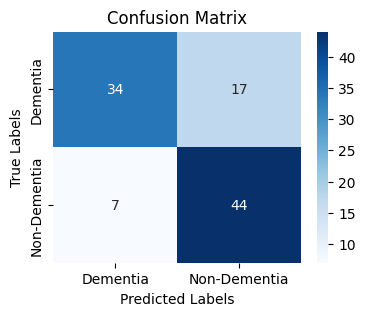

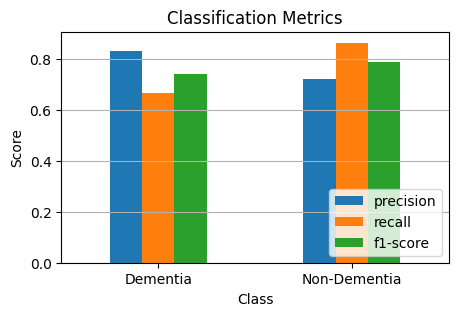

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# Load target variable
y = cleaned_df['class']  # Dementia or Non-Dementia

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converts 'Dementia'/'Non-Dementia' to numeric

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Initialize and train SVM with linear kernel
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Save the trained SVM model for future use
svm_model_path = r'C:\Users\mdnah\OneDrive\Desktop\TranscriptionDetection\ML_Models\SVM_Model.pkl'
with open(svm_model_path, 'wb') as f:
    pickle.dump(svm_model, f)
print(f"SVM model saved to: {svm_model_path}")

# Cross-Validation Accuracy
cv_scores = cross_val_score(svm_model, X_tfidf, y_encoded, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Training accuracy
y_train_pred = svm_model.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {training_accuracy:.2f}")

# Predict on the test data
y_pred_svm = svm_model.predict(X_test)

# Testing accuracy
testing_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Testing Accuracy: {testing_accuracy:.2f}")

# Evaluate the model
print("SVM Classification Report:")
report = classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_, output_dict=True)
print(pd.DataFrame(report).transpose())

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix as Heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Extract metrics for visualization
metrics_df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

# Visualize Precision, Recall, and F1-Score
metrics_df.plot(kind='bar', figsize=(5, 3))
plt.title('Classification Metrics')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()


RBF SVM Model

RBF SVM model saved to: C:\Users\AsifAK\Desktop\Code_Detect_Dementia\ML_Models\SVM_Model_RBF.pkl
Cross-Validation Accuracy: 0.69 ± 0.03
Training Accuracy: 1.00
Testing Accuracy: 0.75
SVM Classification Report (RBF Kernel):
              precision    recall  f1-score     support
Dementia       0.882353  0.588235  0.705882   51.000000
Non-Dementia   0.691176  0.921569  0.789916   51.000000
accuracy       0.754902  0.754902  0.754902    0.754902
macro avg      0.786765  0.754902  0.747899  102.000000
weighted avg   0.786765  0.754902  0.747899  102.000000
Confusion Matrix (RBF Kernel):
[[30 21]
 [ 4 47]]


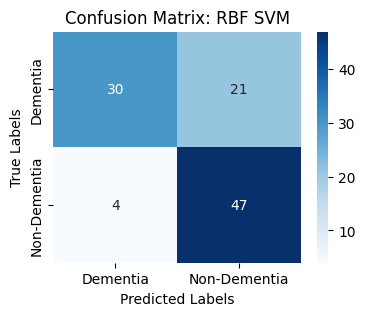

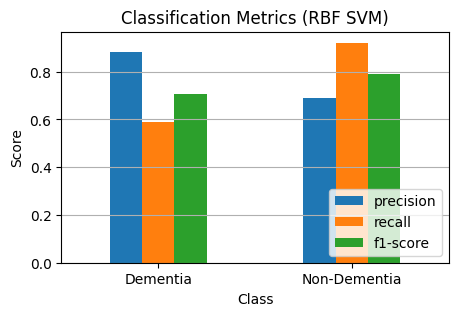

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# Load target variable
y = cleaned_df['class']  # Dementia or Non-Dementia

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converts 'Dementia'/'Non-Dementia' to numeric

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Initialize and train SVM with RBF kernel
svm_model_rbf = SVC(kernel='rbf', gamma='scale', C=1, class_weight='balanced', random_state=42)
svm_model_rbf.fit(X_train, y_train)

# Save the trained RBF SVM model for future use
svm_model_path = r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\ML_Models\SVM_Model_RBF.pkl'
with open(svm_model_path, 'wb') as f:
    pickle.dump(svm_model_rbf, f)
print(f"RBF SVM model saved to: {svm_model_path}")

# Cross-Validation Accuracy
cv_scores = cross_val_score(svm_model_rbf, X_tfidf, y_encoded, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Training accuracy
y_train_pred = svm_model_rbf.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {training_accuracy:.2f}")

# Predict on the test data
y_pred_svm_rbf = svm_model_rbf.predict(X_test)

# Testing accuracy
testing_accuracy = accuracy_score(y_test, y_pred_svm_rbf)
print(f"Testing Accuracy: {testing_accuracy:.2f}")

# Evaluate the model
print("SVM Classification Report (RBF Kernel):")
report = classification_report(y_test, y_pred_svm_rbf, target_names=label_encoder.classes_, output_dict=True)
print(pd.DataFrame(report).transpose())

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm_rbf)
print("Confusion Matrix (RBF Kernel):")
print(conf_matrix)

# Visualize Confusion Matrix as Heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: RBF SVM')
plt.show()

# Extract metrics for visualization
metrics_df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

# Visualize Precision, Recall, and F1-Score
metrics_df.plot(kind='bar', figsize=(5, 3))
plt.title('Classification Metrics (RBF SVM)')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()


See the predicted results

In [ ]:
# Split the dataset into training and testing sets (saving indices)
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_tfidf, y_encoded, cleaned_df.index, test_size=0.3, random_state=42, stratify=y_encoded
)

# Retrieve the sentences corresponding to the test data using test_indices
test_sentences = cleaned_df.loc[test_indices, 'transcribed_text'].values

# Create a DataFrame with predictions, true labels, and sentences
test_results = pd.DataFrame({
    'Sentence': test_sentences,
    'True Label': label_encoder.inverse_transform(y_test),
    'Predicted Label': label_encoder.inverse_transform(y_pred_svm_rbf)
})

# Add a column to indicate if the prediction was correct
test_results['Correct Prediction'] = test_results['True Label'] == test_results['Predicted Label']

# Save the results to a CSV file for further analysis
test_results_path = r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\SVM_RBF_Test_Results_With_Sentences.csv'
test_results.to_csv(test_results_path, index=False)
print(f"Test predictions with sentences saved to: {test_results_path}")

# Display the first few rows of the results
print(test_results.head(10))


ValueError: y contains previously unseen labels: ['Dementia' 'Non-Dementia']

LSTM with word2vec and concatinate with Tf-Idf

Epoch 1/20


c:\Users\AsifAK\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_67', 'keras_tensor_69']. Received: the structure of inputs=('*', '*')
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5830 - loss: 0.6889 - val_accuracy: 0.5294 - val_loss: 0.6904
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7673 - loss: 0.6718 - val_accuracy: 0.6078 - val_loss: 0.6866
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9291 - loss: 0.6497 - val_accuracy: 0.6667 - val_loss: 0.6815
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9966 - loss: 0.6214 - val_accuracy: 0.7059 - val_loss: 0.6743
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9858 - loss: 0.5862 - val_accuracy: 0.7451 - val_loss: 0.6643
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9871 - loss: 0.5463 - val_accuracy: 0.7451 - val_loss: 0.6513
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.4886 - val_accuracy: 0.7451 - val_loss: 0.6365
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9953 - loss: 0.4320 - val_accuracy: 0.7549 - val_loss: 0.6198
Epoch 9/20
8/

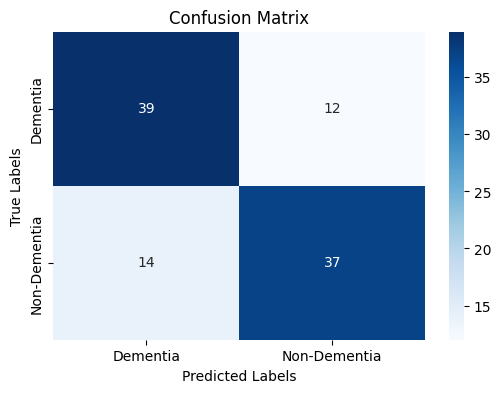

Cross-Validation Accuracy: 0.99 ± 0.02
Hybrid LSTM model saved to: C:\Users\AsifAK\Desktop\Code_Detect_Dementia\ML_Models\Hybrid_LSTM_Model.h5


In [37]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# ===== Load Features =====
# Load Word2Vec features
word2vec_matrix_path = r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\Features\Word2Vec_Features.pkl'
with open(word2vec_matrix_path, 'rb') as f:
    X_word2vec = pickle.load(f)

# Load TF-IDF features
tfidf_matrix_path = r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\Features\TFIDF_Features.pkl'
with open(tfidf_matrix_path, 'rb') as f:
    X_tfidf = pickle.load(f)

# Convert sparse TF-IDF matrix to dense
X_tfidf_dense = X_tfidf.toarray()

# Load the target variable
y = cleaned_df['class']
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# ===== Split Dataset =====
X_train_w2v, X_test_w2v, X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_word2vec, X_tfidf_dense, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Reshape Word2Vec features for LSTM input
X_train_w2v = X_train_w2v.reshape((X_train_w2v.shape[0], 1, X_train_w2v.shape[1]))
X_test_w2v = X_test_w2v.reshape((X_test_w2v.shape[0], 1, X_test_w2v.shape[1]))

# Convert target to categorical (for binary classification)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# ===== Build Hybrid Model =====
# Input 1: Word2Vec features for LSTM
input_w2v = Input(shape=(1, X_train_w2v.shape[2]))
lstm_layer = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(input_w2v)

# Input 2: TF-IDF features
input_tfidf = Input(shape=(X_train_tfidf.shape[1],))

# Concatenate LSTM and TF-IDF outputs
concat_layer = Concatenate()([lstm_layer, input_tfidf])
dense_layer = Dense(64, activation='relu')(concat_layer)
dropout_layer = Dropout(0.3)(dense_layer)
output_layer = Dense(2, activation='softmax')(dropout_layer)

# Define the model
hybrid_model = Model(inputs=[input_w2v, input_tfidf], outputs=output_layer)

# Compile the model
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ===== Train the Model =====
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = hybrid_model.fit(
    [X_train_w2v, X_train_tfidf], y_train_categorical,
    validation_data=([X_test_w2v, X_test_tfidf], y_test_categorical),
    epochs=20, batch_size=32, callbacks=[early_stopping], verbose=1
)

# ===== Evaluate the Model =====
train_loss, train_accuracy = hybrid_model.evaluate([X_train_w2v, X_train_tfidf], y_train_categorical, verbose=0)
test_loss, test_accuracy = hybrid_model.evaluate([X_test_w2v, X_test_tfidf], y_test_categorical, verbose=0)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Predict on test data
y_pred = np.argmax(hybrid_model.predict([X_test_w2v, X_test_tfidf]), axis=1)

# ===== Classification Report =====
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# ===== Confusion Matrix =====
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ===== Cross-Validation =====
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in cv.split(X_word2vec, y_encoded):
    X_train_cv_w2v, X_val_cv_w2v = X_word2vec[train_idx], X_word2vec[val_idx]
    X_train_cv_tfidf, X_val_cv_tfidf = X_tfidf_dense[train_idx], X_tfidf_dense[val_idx]
    y_train_cv, y_val_cv = y_encoded[train_idx], y_encoded[val_idx]

    # Reshape Word2Vec for LSTM input
    X_train_cv_w2v = X_train_cv_w2v.reshape((X_train_cv_w2v.shape[0], 1, X_train_cv_w2v.shape[1]))
    X_val_cv_w2v = X_val_cv_w2v.reshape((X_val_cv_w2v.shape[0], 1, X_val_cv_w2v.shape[1]))

    # Convert target to categorical
    y_train_cv_cat = to_categorical(y_train_cv)
    y_val_cv_cat = to_categorical(y_val_cv)

    # Train and evaluate
    hybrid_model.fit([X_train_cv_w2v, X_train_cv_tfidf], y_train_cv_cat, epochs=10, batch_size=32, verbose=0)
    val_loss, val_accuracy = hybrid_model.evaluate([X_val_cv_w2v, X_val_cv_tfidf], y_val_cv_cat, verbose=0)
    cv_scores.append(val_accuracy)

print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# ===== Save the Model =====
model_path = r'C:\Users\AsifAK\Desktop\Code_Detect_Dementia\ML_Models\Hybrid_LSTM_Model.h5'
hybrid_model.save(model_path)
print(f"Hybrid LSTM model saved to: {model_path}")
